In [ ]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import os
from urllib.parse import urlparse, parse_qs
import re
import ipaddress
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [ ]:
# Load dataset
malicious_data = pd.read_csv('/content/malicious_phish.csv')

In [ ]:
malicious_data.head()


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
malicious_data['type'].value_counts()


,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [ ]:
malicious_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


## EXPLORATORY DATA ANALYSIS

In [ ]:
# Map types to numerical values
type_mapping = {
    'malware': 3,
    'defacement': 2,
    'phishing': 1,
    'benign': 0
}
malicious_data['type'] = malicious_data['type'].map(type_mapping)

In [ ]:

def get_url_len(url):
    return len(url)
def extract_domain_length(url):
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url
        domain = urlparse(url).netloc
        return len(domain) if domain else 0
    except Exception:
        return 0


def has_http(url):
    return int(url.startswith('http://'))

def has_https(url):
    return int(url.startswith('https://'))

def count_dots(url):
    return url.count('.')

def count_dashes(url):
    return url.count('-')

def count_underscores(url):
    return url.count('_')

def count_ques(url):
    return url.count('?')

def count_slashes(url):
    return url.count('/')

def count_special_chars(url):
    return len(re.findall(r'\W', url))

def count_digits(url):
    return len(re.findall(r'\d', url))

def count_letters(url):
    return len(re.findall(r'[a-zA-Z]', url))

def has_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass
    return 0

def count_url_parameters(url):
    return len(parse_qs(urlparse(url).query))

def check_php_in_url(url):
    return int('php' in url.lower())

def check_html_in_url(url):
    return int('html' in url.lower())

def check_mal_tld(url):
    tld_list = ['.tk', '.buzz', '.xyz', '.top', '.ga', '.ml', '.info', '.cf', '.gq', '.icu', '.wang', '.live', '.host', '.shop', '.vip', '.id', '.cc', '.br', '.ci', '.zw', '.sx', '.mw']
    return int(any(urlparse(url).netloc.lower().endswith(tld) for tld in tld_list))

def is_shortened_url(url):
    shortened_services = [
        "bit.ly", "tinyurl.com", "goo.gl", "t.co", "ow.ly", "buff.ly",
        "is.gd", "adf.ly", "bit.do", "cutt.ly", "v.gd", "shorte.st",
        "bl.ink", "x.co", "s.id", "trib.al"
    ]
    return int(any(service in urlparse(url).netloc.lower() for service in shortened_services))


In [ ]:
# Apply feature extraction
malicious_data['url_length'] = malicious_data['url'].str.len()
malicious_data['domain_length'] = malicious_data['url'].apply(extract_domain_length)
malicious_data['check_http'] = malicious_data['url'].apply(has_http)
malicious_data['check_https'] = malicious_data['url'].apply(has_https)
malicious_data['dot_count'] = malicious_data['url'].apply(count_dots)
malicious_data['dash_count'] = malicious_data['url'].apply(count_dashes)
malicious_data['underscore_count'] = malicious_data['url'].apply(count_underscores)
malicious_data['ques_count'] = malicious_data['url'].apply(count_ques)
malicious_data['slash_count'] = malicious_data['url'].apply(count_slashes)
malicious_data['special_chars_count'] = malicious_data['url'].apply(count_special_chars)
malicious_data['digits_count'] = malicious_data['url'].apply(count_digits)
malicious_data['letters_count'] = malicious_data['url'].apply(count_letters)
malicious_data['has_ip'] = malicious_data['url'].apply(has_ip_address).astype(int)
malicious_data['param_count'] = malicious_data['url'].apply(count_url_parameters)
malicious_data['has_php'] = malicious_data['url'].apply(check_php_in_url)
malicious_data['has_html'] = malicious_data['url'].apply(check_html_in_url)
malicious_data['mal_tld'] = malicious_data['url'].apply(check_mal_tld)
malicious_data['shortened'] = malicious_data['url'].apply(is_shortened_url)

In [ ]:
malicious_data.head()

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0


In [ ]:
# Split the dataset
x = malicious_data.drop(columns=['url', 'type'])
y = malicious_data['type']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
print(f"X_train Shape : {x_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {x_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (455833, 18)
Y_train Shape : (455833,)
X_test  Shape : (195358, 18)
Y_test  Shape : (195358,)


DecisionTreeClassifier
Test Accuracy:   93.83%  
 Classification Report 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    128733
           1       0.80      0.78      0.79     28234
           2       0.96      0.97      0.97     28692
           3       0.95      0.93      0.94      9699

    accuracy                           0.94    195358
   macro avg       0.92      0.91      0.92    195358
weighted avg       0.94      0.94      0.94    195358

 Confusion Matrix 


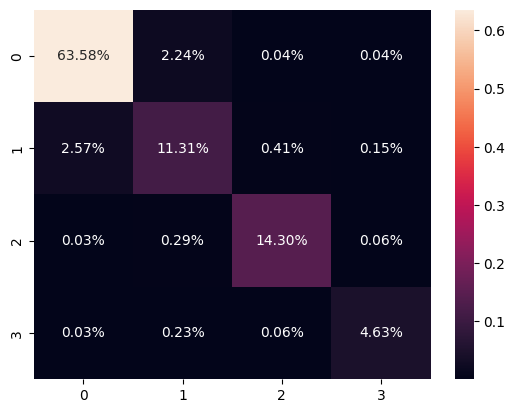

RandomForestClassifier
Test Accuracy:   94.88%  
 Classification Report 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    128733
           1       0.85      0.80      0.82     28234
           2       0.97      0.99      0.98     28692
           3       0.98      0.94      0.96      9699

    accuracy                           0.95    195358
   macro avg       0.94      0.92      0.93    195358
weighted avg       0.95      0.95      0.95    195358

 Confusion Matrix 


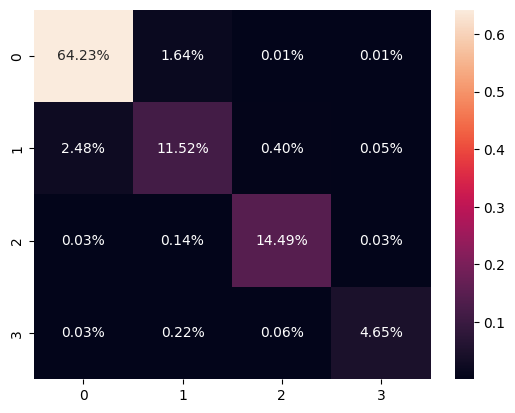

ExtraTreesClassifier
Test Accuracy:   94.77%  
 Classification Report 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    128733
           1       0.85      0.79      0.82     28234
           2       0.97      0.98      0.98     28692
           3       0.98      0.94      0.96      9699

    accuracy                           0.95    195358
   macro avg       0.94      0.92      0.93    195358
weighted avg       0.95      0.95      0.95    195358

 Confusion Matrix 


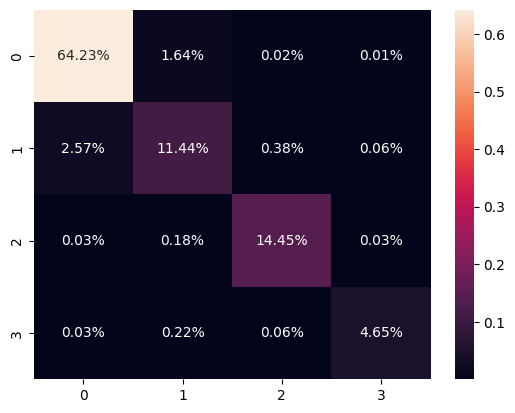

In [ ]:
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier()
]

accuracy_test = []
for model_ in models:
    print(model_.__class__.__name__)
    model_.fit(x_train, y_train)
    pred = model_.predict(x_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print(f'Test Accuracy: \033[32m \033[01m {acc * 100:.2f}% \033[30m \033[0m')
    print('\033[01m Classification Report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m Confusion Matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='0.2%')
    plt.show()

In [ ]:
output = pd.DataFrame({
    "Model": ['Decision Tree Classifier', 'Random Forest Classifier', 'Extra Trees Classifier'],
    "Accuracy": accuracy_test
})


In [ ]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='center', size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel("Models", size=14)
plt.xticks(rotation=20)
plt.ylabel("Accuracy", size=14)
plt.show()



**SAVE THE TRAINED MODEL**

In [ ]:
import pickle

In [ ]:
import pickle

# Save each model separately
model_names = ['DecisionTree', 'RandomForest', 'ExtraTrees']
for model, name in zip(models, model_names):
    filename = f'{name}_model.sav'
    pickle.dump(model, open(filename, 'wb'))


In [ ]:
loaded_models = {}
for name in model_names:
    filename = f'{name}_model.sav'
    loaded_models[name] = pickle.load(open(filename, 'rb'))
